In [26]:
# importing dependencies
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

# For model building
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Optimizations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

In [2]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data

temp = []
for x in [2010 + x for x in range(8)] :
#   add dtype declaration to remove warning
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
                   # dtype = {"Start station ID" : pd.int64, "End station ID" : pd.int64, "Account type": pd.Categorical}
    temp.append(x)
    nr = pd.concat(temp)

/home/grimoire/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Changing dates from objects into datetimes
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start date'] = nr['Start date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))
nr['End date'] = nr['End date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [4]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 10 columns):
STATION    2922 non-null object
NAME       2922 non-null object
DATE       2922 non-null datetime64[ns]
AWND       2922 non-null float64
PRCP       2922 non-null float64
SNOW       2922 non-null float64
SNWD       2922 non-null int64
TAVG       2922 non-null float64
TMAX       2922 non-null int64
TMIN       2922 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 228.4+ KB


In [6]:
nr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694187 entries, 0 to 460715
Data columns (total 8 columns):
Start date                  datetime64[ns]
Start station               object
Start station ID            object
End date                    datetime64[ns]
End station                 object
End station ID              object
Account type                object
Total duration (seconds)    int64
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 185.0+ MB


In [7]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start date', 'Total duration (seconds)']].resample('D', on='Start date').count()
daily_totals = daily_totals.drop('Start date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"Total duration (seconds)": "Dcount",'Start date':'DATE'})

In [8]:
daily_totals.info()
daily_totals.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2709 entries, 0 to 2708
Data columns (total 2 columns):
DATE      2709 non-null datetime64[ns]
Dcount    2709 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 63.5+ KB


,DATE,Dcount
0,2010-06-07,1
1,2010-06-08,2
2,2010-06-09,7
3,2010-06-10,104
4,2010-06-11,287


In [9]:
weather.keys()
weather = weather.drop(['STATION', 'NAME', 'SNOW', 'SNWD'], axis=1)

In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 6 columns):
DATE    2922 non-null datetime64[ns]
AWND    2922 non-null float64
PRCP    2922 non-null float64
TAVG    2922 non-null float64
TMAX    2922 non-null int64
TMIN    2922 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 137.0 KB


In [11]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 7 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
Dcount    2709 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 182.6 KB


,DATE,AWND,PRCP,TAVG,TMAX,TMIN,Dcount
0,2010-01-01,8.95,0.0,-1.5,6,-9,NaN
1,2010-01-02,4.03,0.0,-7.0,1,-15,NaN
2,2010-01-03,2.91,0.0,-3.5,7,-14,NaN
3,2010-01-04,5.59,0.0,-1.5,7,-10,NaN
4,2010-01-05,3.13,0.0,0.5,10,-9,NaN


In [53]:
train_test_data = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 7 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
Dcount    2922 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 182.6 KB


In [54]:
# Need to drop all days where there where no rides taken (Dcount = 0)

temp[temp['Dcount'] == 0].Dcount

311     0.0
312     0.0
313     0.0
314     0.0
315     0.0
316     0.0
317     0.0
318     0.0
319     0.0
320     0.0
321     0.0
322     0.0
323     0.0
324     0.0
325     0.0
326     0.0
327     0.0
328     0.0
329     0.0
330     0.0
331     0.0
332     0.0
333     0.0
334     0.0
335     0.0
336     0.0
337     0.0
338     0.0
339     0.0
340     0.0
       ... 
2619    0.0
2620    0.0
2621    0.0
2622    0.0
2623    0.0
2624    0.0
2625    0.0
2626    0.0
2627    0.0
2628    0.0
2629    0.0
2630    0.0
2631    0.0
2632    0.0
2633    0.0
2634    0.0
2635    0.0
2636    0.0
2637    0.0
2638    0.0
2639    0.0
2640    0.0
2641    0.0
2642    0.0
2643    0.0
2644    0.0
2645    0.0
2646    0.0
2647    0.0
2648    0.0
Name: Dcount, Length: 1042, dtype: float64

In [34]:
X = train_test_data.drop(['DATE', 'AWND', 'PRCP', 'TAVG', 'TMIN', 'Dcount'], axis=1)
# X = train_test_data.drop(['DATE', 'AWND', 'PRCP', 'TAVG', 'TMIN', 'Dcount'], axis=1)
y = train_test_data.drop(['DATE', 'AWND', 'PRCP', 'TAVG','TMAX', 'TMIN'], axis=1)

In [38]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709 entries, 157 to 2865
Data columns (total 1 columns):
TMAX    2709 non-null int64
dtypes: int64(1)
memory usage: 42.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709 entries, 157 to 2865
Data columns (total 1 columns):
Dcount    2709 non-null float64
dtypes: float64(1)
memory usage: 42.3 KB


In [43]:
print(X.describe())
print(y.describe())

              TMAX
count  2709.000000
mean     57.293835
std      23.775834
min     -12.000000
25%      37.000000
50%      61.000000
75%      78.000000
max     103.000000
            Dcount
count  2709.000000
mean    994.531931
std    1058.519993
min       0.000000
25%       0.000000
50%     722.000000
75%    1732.000000
max    5625.000000


**Why are there so many zeroes in DCount**

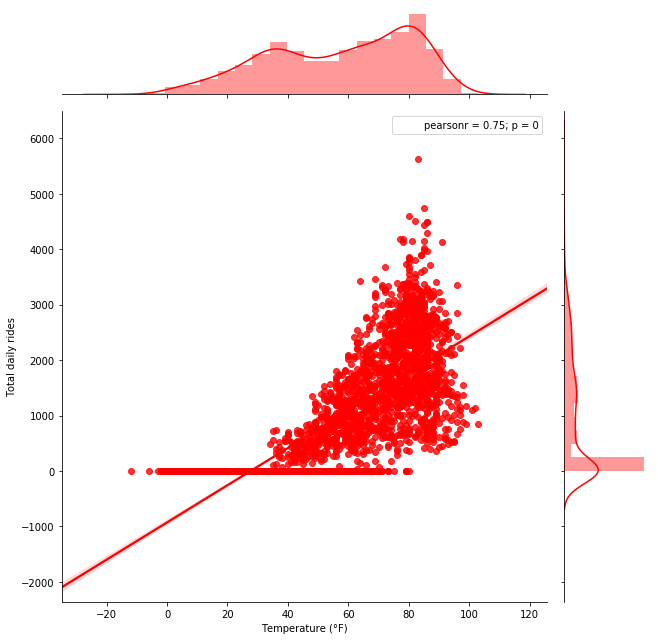

In [41]:
sns.jointplot(X.TMAX, y.Dcount, kind='reg', color='r', size=9)
plt.xlabel('Temperature (°F)')
plt.ylabel('Total daily rides')
plt.margins(.02)

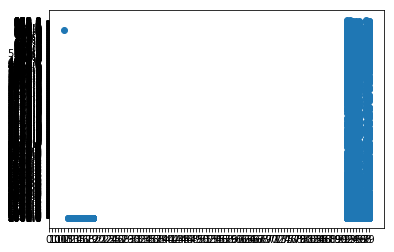

In [39]:
plt.scatter(X,y)
plt.show()

In [37]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=.3, random_state=42) # for Douglas Adams.

lin_reg = LinearRegression()

lin_reg.fit(Xlr, ylr)

# Predict the labels
y_pred = lin_reg.predict(Xlr)
# Print the accuracy from the testing data.
print(accuracy_score(lin_reg.predict(Xtestlr), ytestlr))
print(confusion_matrix(ylr, y_pred))
print(classification_report(ylr, y_pred))

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [23]:
'''
# Split the data into a training and test set.

Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=.3, random_state=42) # for Douglas Adams.

log_reg = LogisticRegression()

# Fit the model on the trainng data.
log_reg.fit(Xlr, ylr)

# Predict the labels
y_pred = log_reg.predict(Xlr)
# Print the accuracy from the testing data.
print(accuracy_score(log_reg.predict(Xtestlr), ytestlr))
print(confusion_matrix(ylr, y_pred))
print(classification_report(ylr, y_pred))
'''

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3874538745387454
[[726   0   0 ...   0   0   0]
 [ 10   0   0 ...   0   0   0]
 [  3   0   0 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
             precision    recall  f1-score   support

        0.0       0.45      1.00      0.62       726
        1.0       0.00      0.00      0.00        10
        2.0       0.00      0.00      0.00         3
        4.0       0.00      0.00      0.00         1
        6.0       0.00      0.00      0.00         1
        7.0       0.00      0.00      0.00         1
       30.0       0.00      0.00      0.00         1
       69.0       0.00      0.00      0.00         1
       73.0       0.00      0.00      0.00         1
       87.0       0.00      0.00      0.00         1
      104.0       0.00      0.00      0.00         1
      112.0       0.00      0.00      0.00         1
      126.0       0.00      0.00      0.00         1
      130.0       0.00      0.00      0.00    

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
'''
# Compute predicted probabilities: y_pred_prob
y_pred_prob = log_reg.predict_proba(Xtestlr)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytestlr, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
'''

"\n# Compute predicted probabilities: y_pred_prob\ny_pred_prob = log_reg.predict_proba(Xtestlr)[:,1]\n\n# Generate ROC curve values: fpr, tpr, thresholds\nfpr, tpr, thresholds = roc_curve(ytestlr, y_pred_prob)\n\n# Plot ROC curve\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr, tpr)\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\n"

In [30]:
# Precision-recall Curve
# Goes here

In [33]:
# GridSearchCV
print(log_reg.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>


In [ ]:
# Sinoidal model for fitting
# https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
# https://exnumerus.blogspot.com/2010/04/how-to-fit-sine-wave-example-in-python.html

**0.385 - Back to the drawing board**